In [1]:
import tensorflow as tf
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

def tensor_to_image(tf_input):
  tf_input = tf_input*255
  tf_input = np.array(tf_input, dtype=np.uint8)
  if np.ndim(tf_input)>3:
    assert tf_input.shape[0] == 1
    tf_input = tf_input[0]
  return PIL.Image.fromarray(tf_input)

#input image of your choice
content_path = 'D:\Martina\pluralsight\TensorFlow 2.0, Part 2 Implementation\\field.jpg'

style_path = 'D:\Martina\pluralsight\TensorFlow 2.0, Part 2 Implementation\\bird.jpg'

In [2]:
def load_img(image_path):
  max_dim = 512
  img = tf.io.read_file(image_path)
  img = tf.image.decode_image(img, channels=3)#Detects the image to perform apropriate opertions
  img = tf.image.convert_image_dtype(img, tf.float32)#converts image to tensor dtype

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)# Casts a tensor to float32.

  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)

  return img[tf.newaxis, :]

In [3]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

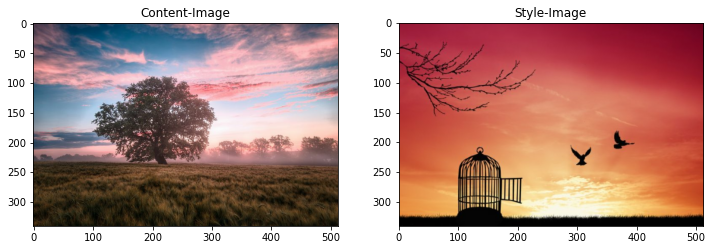

In [4]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content-Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style-Image')

In [5]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574717952/574710816 [==============================] - 225s 0us/step


TensorShape([1, 1000])

In [6]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80142336/80134624 [==============================] - 31s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [7]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [8]:
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  tf_outs = [vgg.get_layer(layer).output for layer in layer_names]

  model = tf.keras.Model([vgg.input], tf_outs)
  return model

In [9]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, tf_out in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", tf_out.numpy().shape)
  print("  min: ", tf_out.numpy().min())
  print("  max: ", tf_out.numpy().max())
  print("  mean: ", tf_out.numpy().mean())
  print()

block1_conv1
  shape:  (1, 341, 512, 64)
  min:  0.0
  max:  816.1883
  mean:  39.33623

block2_conv1
  shape:  (1, 170, 256, 128)
  min:  0.0
  max:  3963.7236
  mean:  159.8728

block3_conv1
  shape:  (1, 85, 128, 256)
  min:  0.0
  max:  7132.7744
  mean:  130.05833

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  15985.436
  mean:  488.3304

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  2972.7974
  mean:  35.836216



### Part 2

In [10]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [11]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

In [12]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.01463329
    max:  29386.947
    mean:  413.82608

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  71234.484
    mean:  11914.402

   block3_conv1
    shape:  (1, 256, 256)
    min:  2.9735785
    max:  255348.33
    mean:  10771.422

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4721173.5
    mean:  171493.69

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  142927.95
    mean:  939.13074

Contents:
   block5_conv2
    shape:  (1, 21, 32, 512)
    min:  0.0
    max:  647.5896
    mean:  11.175125


In [13]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [14]:
image = tf.Variable(content_image)

In [15]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [16]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [17]:
style_weight=1e-2
content_weight=1e4

In [18]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [19]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

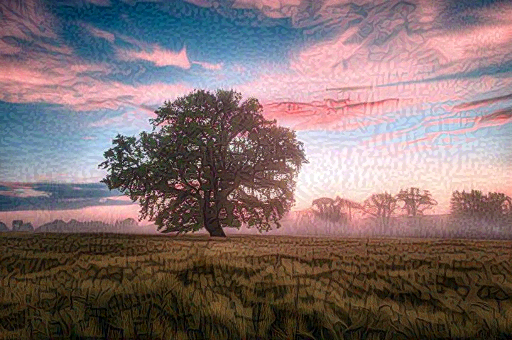

In [20]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

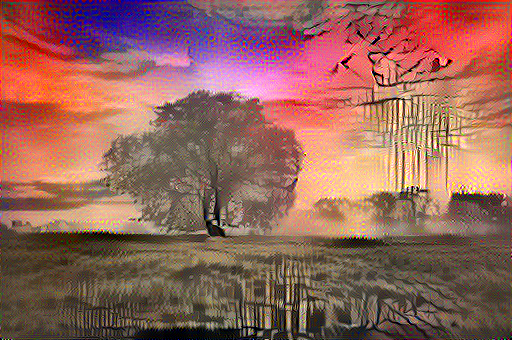

Train step: 1000
Total time: 3235.7


In [21]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

In [22]:
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var

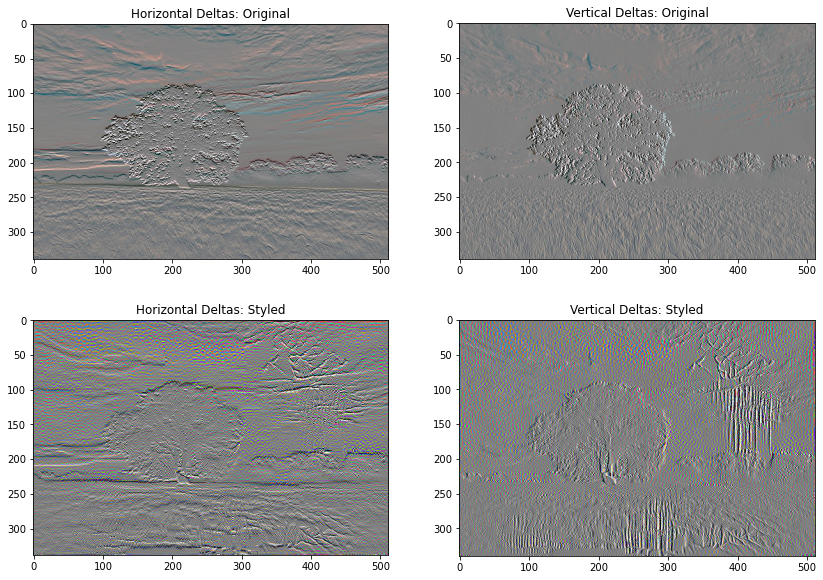

In [23]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

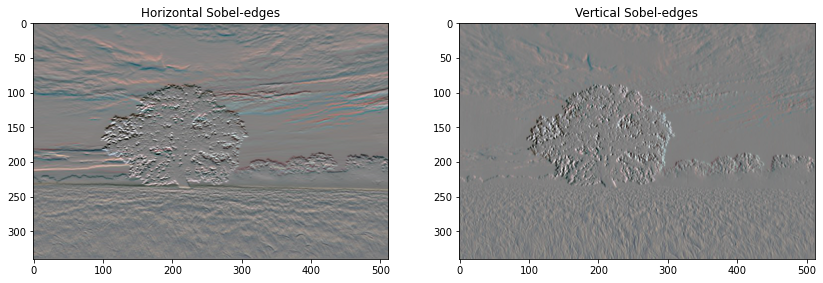

In [24]:
plt.figure(figsize=(14,10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1,2,1)
imshow(clip_0_1(sobel[...,0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1,2,2)
imshow(clip_0_1(sobel[...,1]/4+0.5), "Vertical Sobel-edges")

In [25]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [26]:
total_variation_loss(image).numpy()

90444.84

In [27]:
tf.image.total_variation(image).numpy()

array([90444.84], dtype=float32)

In [28]:
total_variation_weight=30

In [29]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [30]:
image = tf.Variable(content_image)

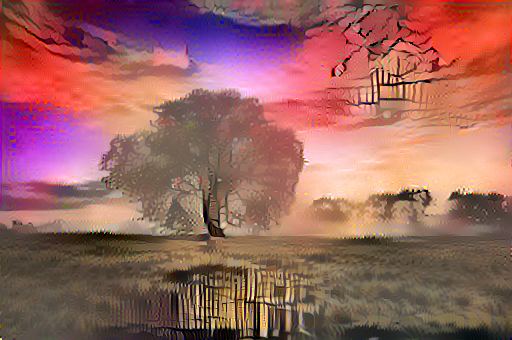

Train step: 1000
Total time: 3224.7


In [31]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))